In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch

SEQ_LEN = 50
NUM_FEATURES = 4 * 25  # 25 landmarks X 4 features each - x,y,z,vis


def read_raw_data(score_path, data_path):
    shot_names = {}

    score_df = pd.read_csv(score_path)
    score_df = score_df[score_df['frames'] < SEQ_LEN]

    data_df = pd.read_csv(data_path)
    amount_of_shots = len(score_df)
    print('all examples:', amount_of_shots)

    single_shot_x = np.zeros((SEQ_LEN, NUM_FEATURES))
    x = np.zeros((amount_of_shots, SEQ_LEN, NUM_FEATURES))
    y = []
    shot_index = 0

    for _, row in tqdm(score_df.iterrows()):

        frames = row['frames']
        score = row['score']
        shot_name = row['name']

        for i in range(0, frames):
            frame_name = shot_name + '_{}'.format(i)
            shot_data = []
            for k, v in data_df[data_df['name'] == frame_name].iteritems():
                if k == 'name':
                    continue
                shot_data.append(v.values[0])
            single_shot_x[i] = np.array(shot_data)

        if shot_index == amount_of_shots:
            break

        y.append(score)
        x[shot_index] = np.nan_to_num(single_shot_x)
        shot_names[shot_index] = shot_name
        shot_index += 1
    return torch.from_numpy(x).float(), np.array(y), shot_names


# keep x and y unchanged
x, y, names = read_raw_data(score_path='labels/fts_score.csv', data_path='labels/fts_data.csv')

all examples: 1371


0it [00:00, ?it/s]

visualization

C:\Users\Adi brucker\PycharmProjects\pythonProject\DL_PROJECT\TT_train\visualization\custom_drawing_utils.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10))


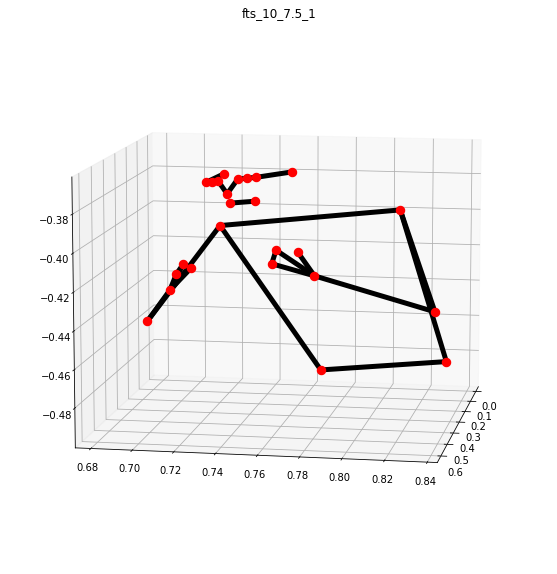

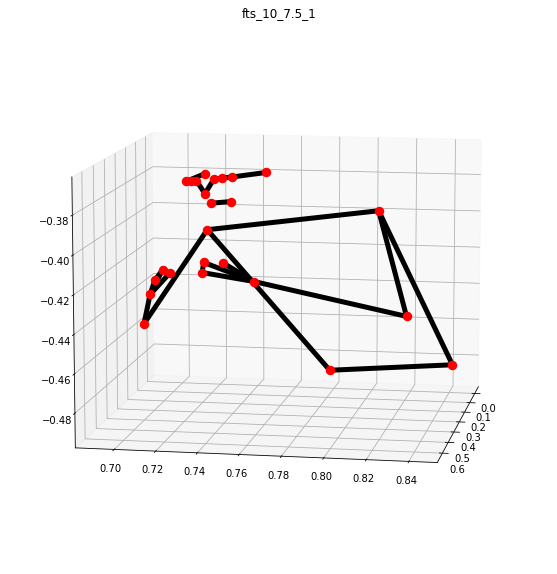

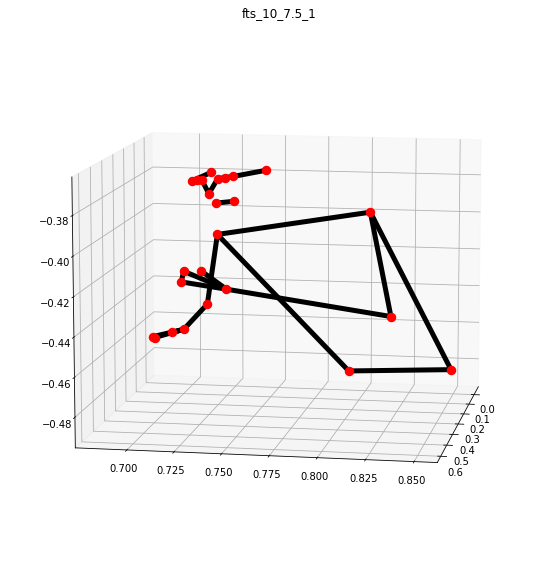

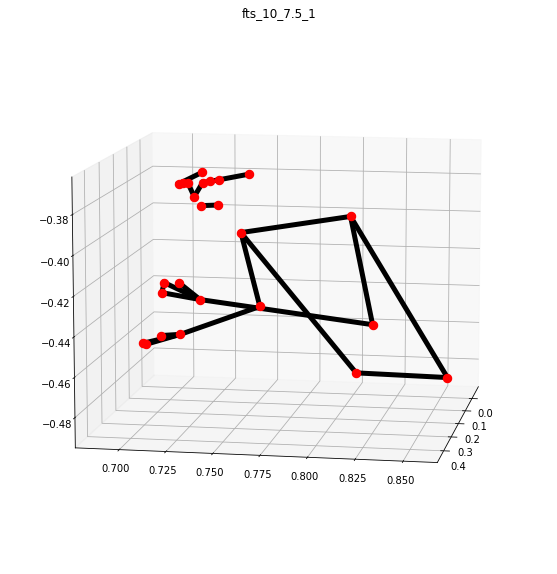

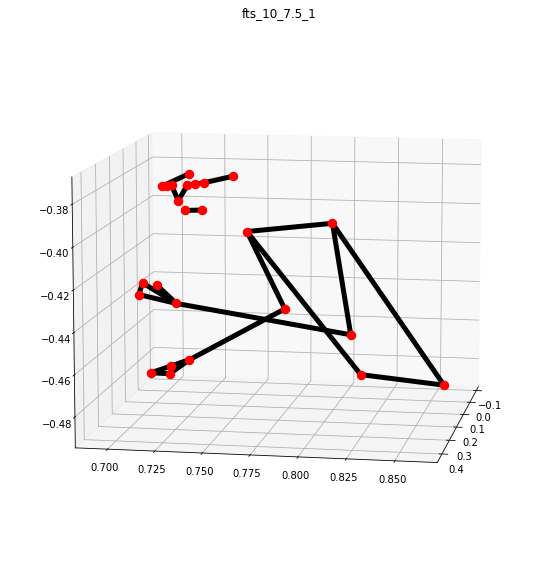

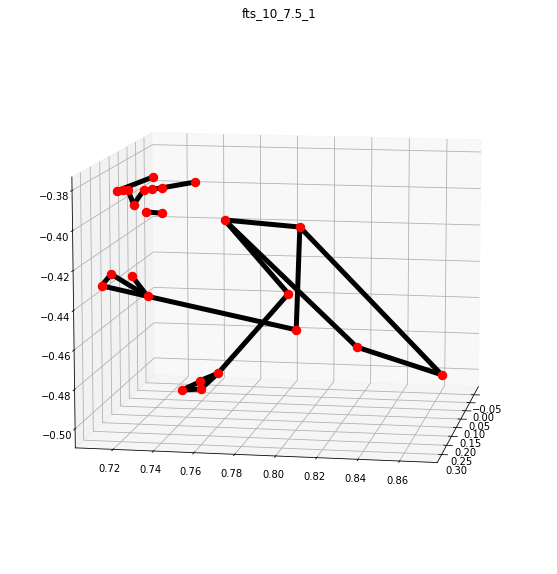

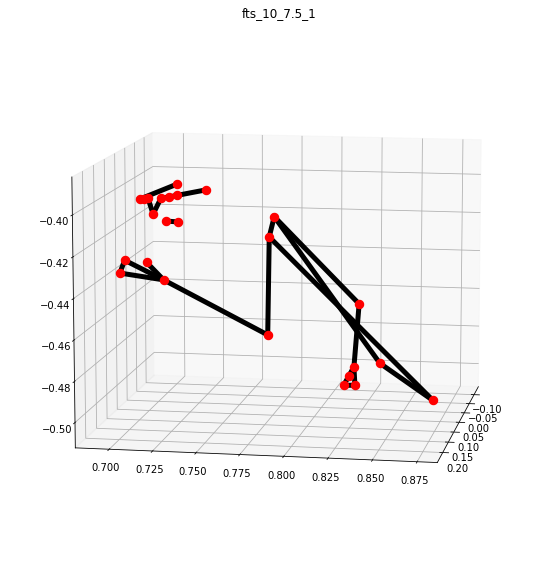

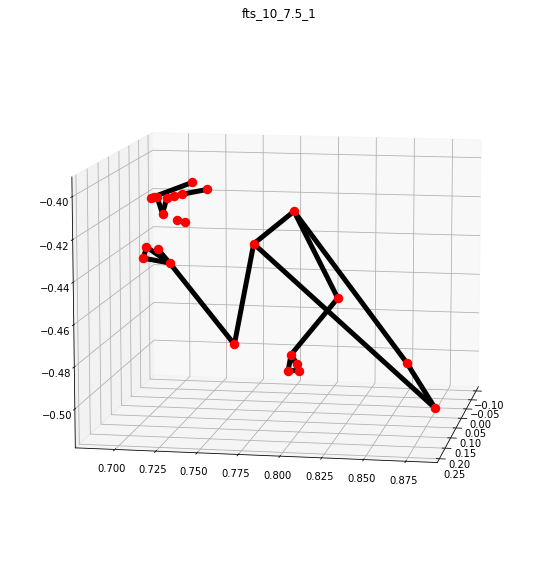

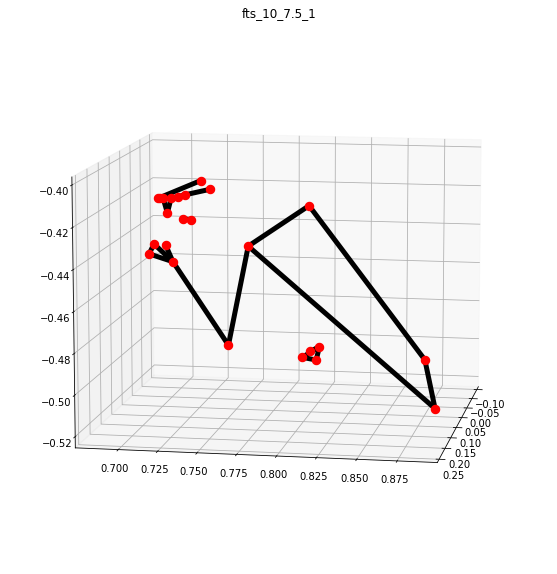

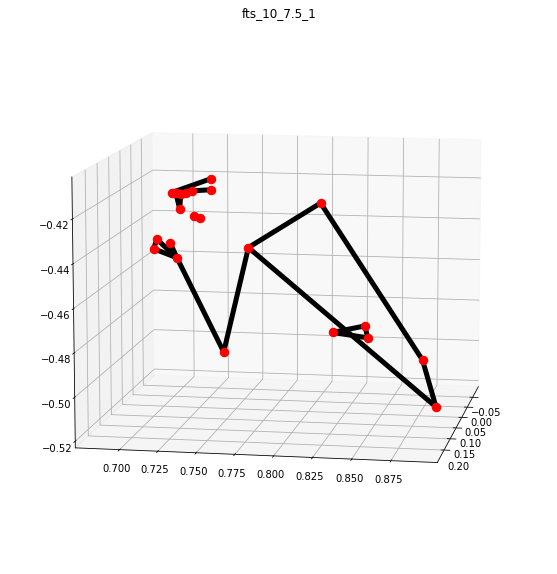

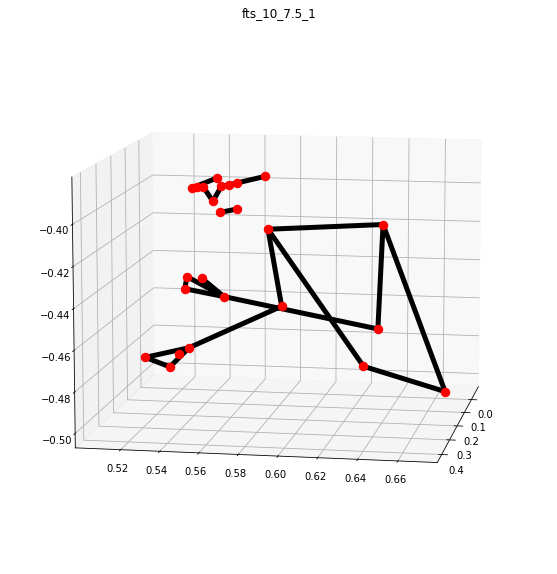

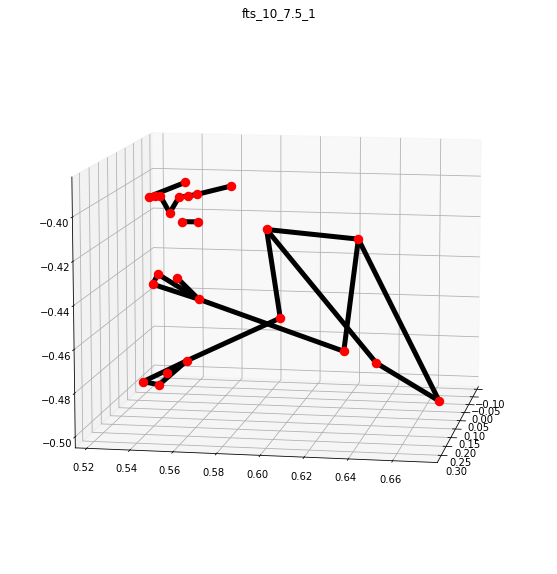

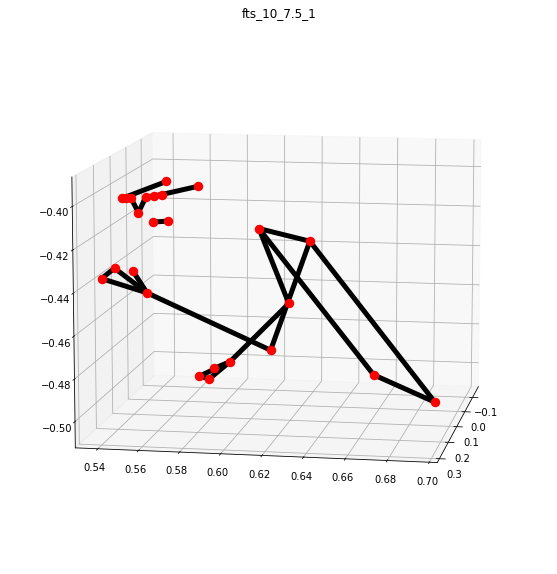

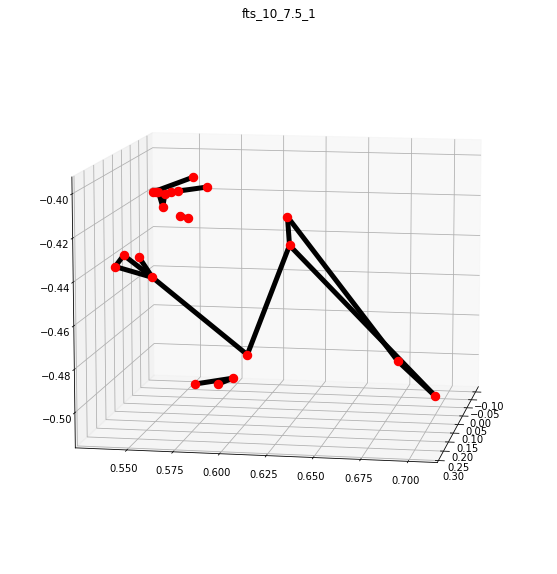

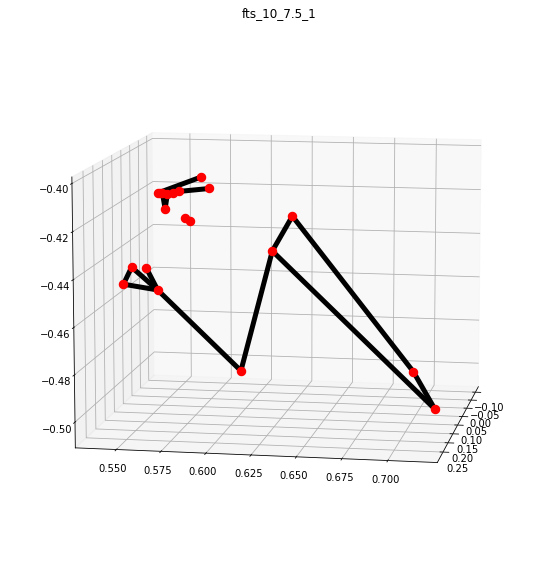

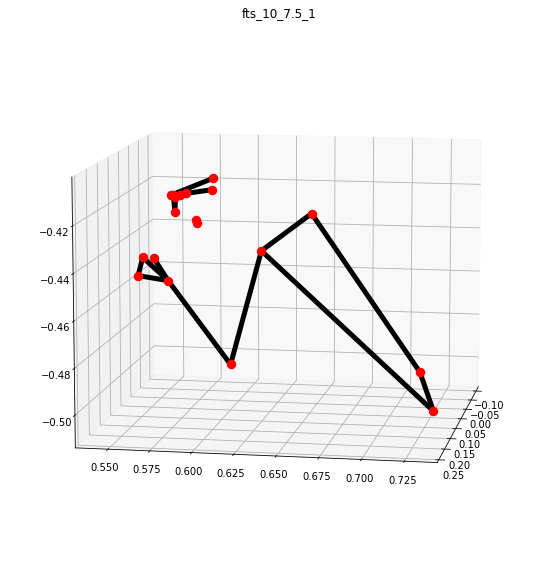

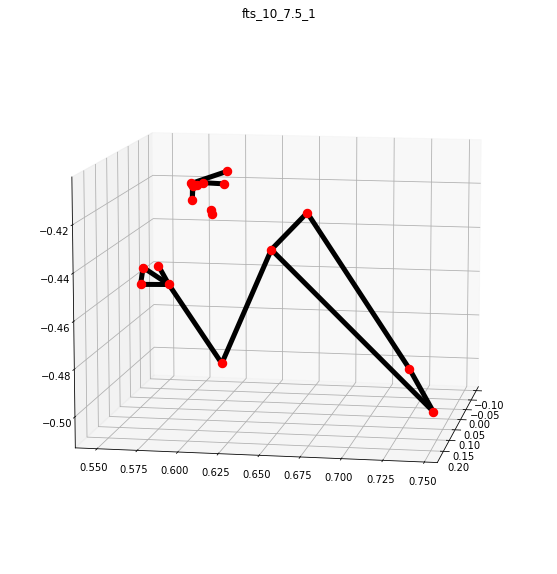

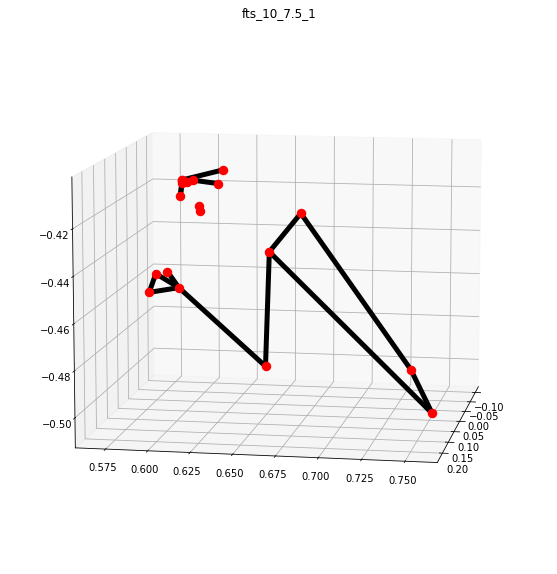

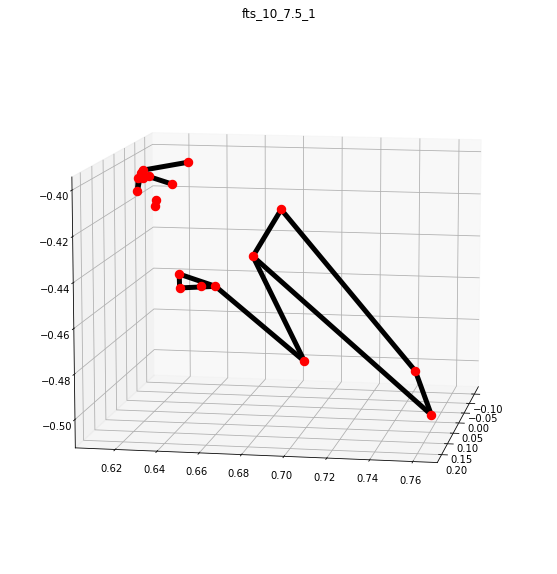

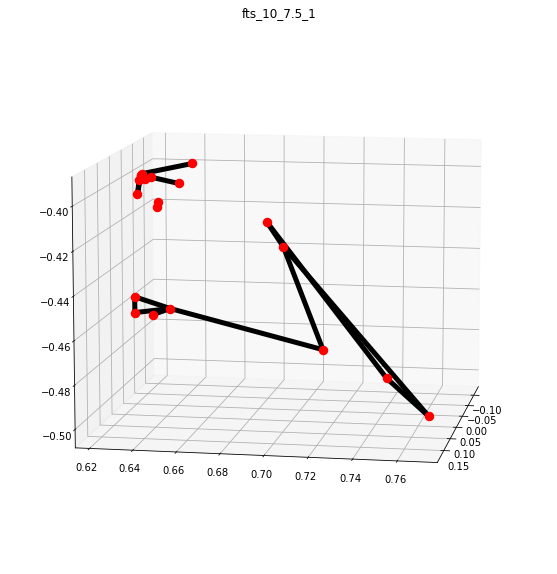

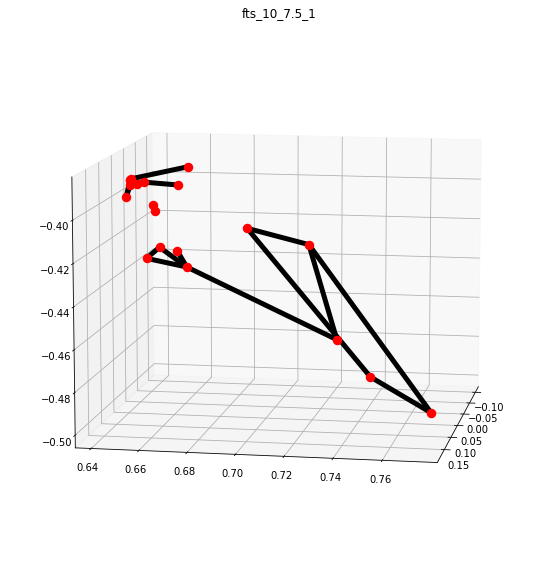

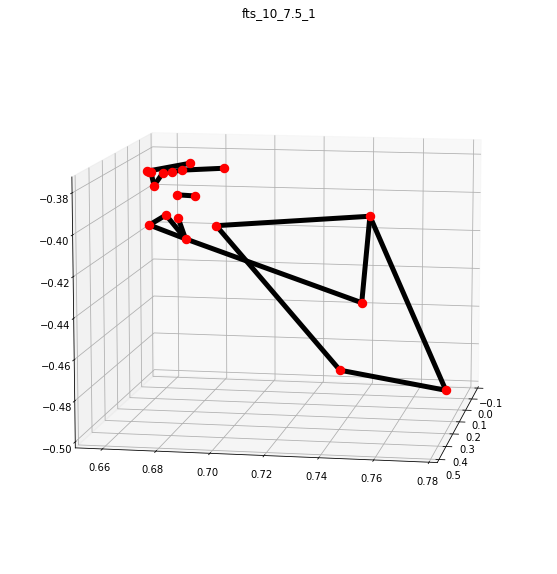

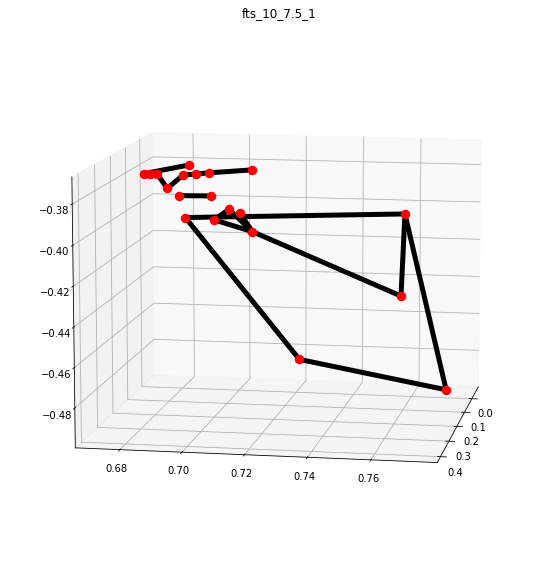

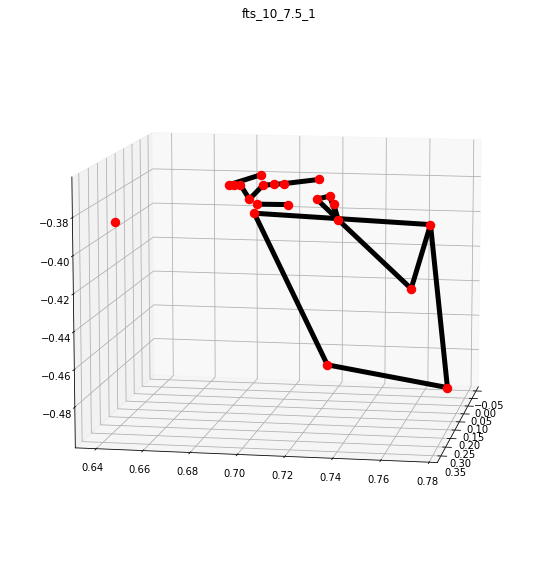

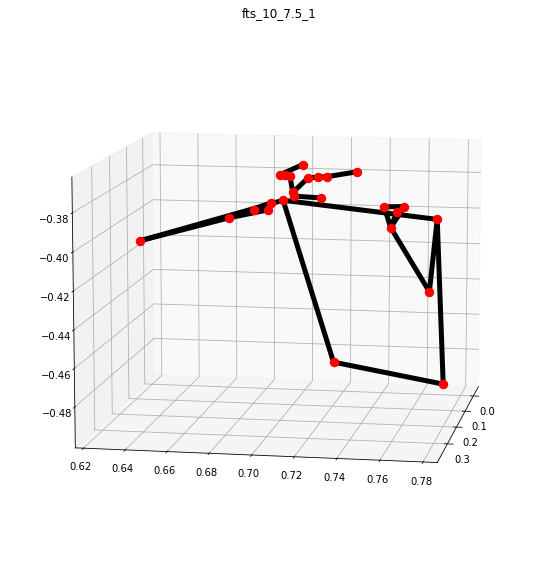

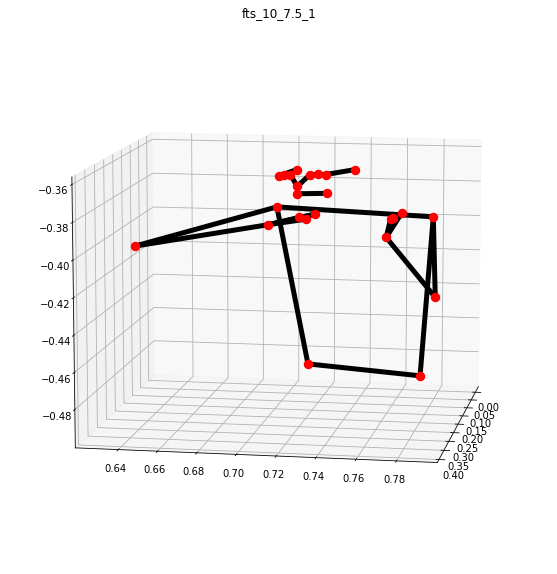

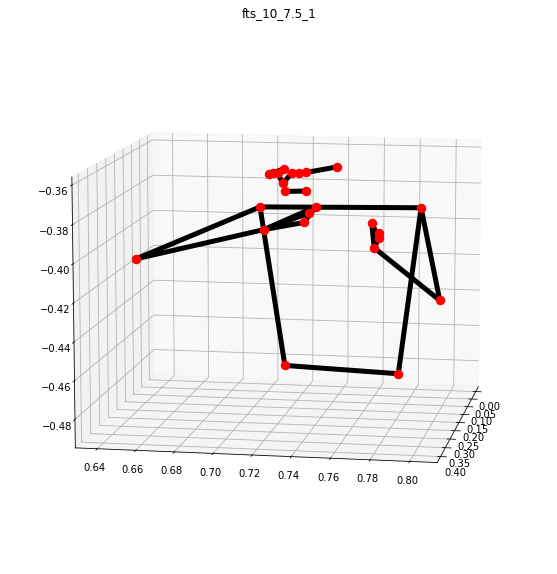

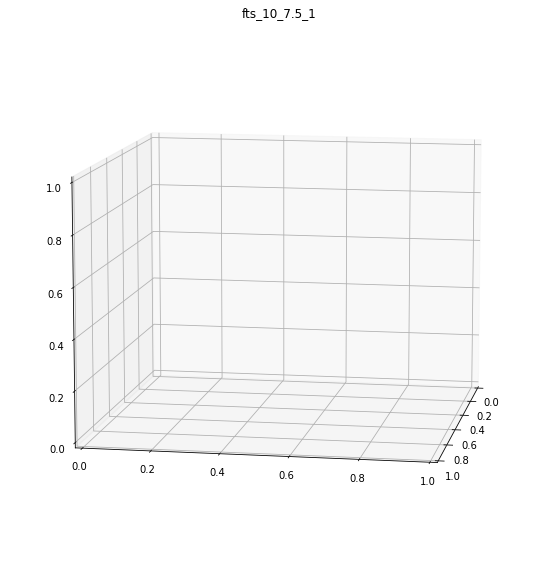

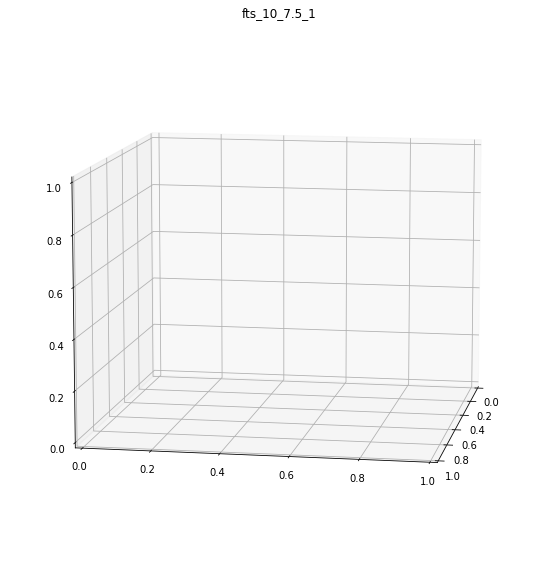

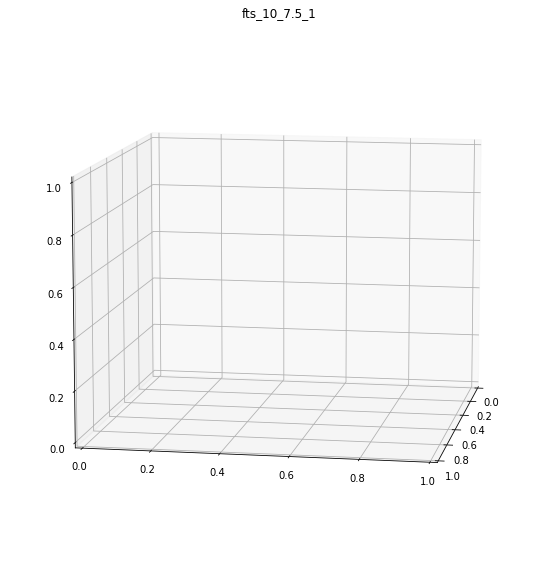

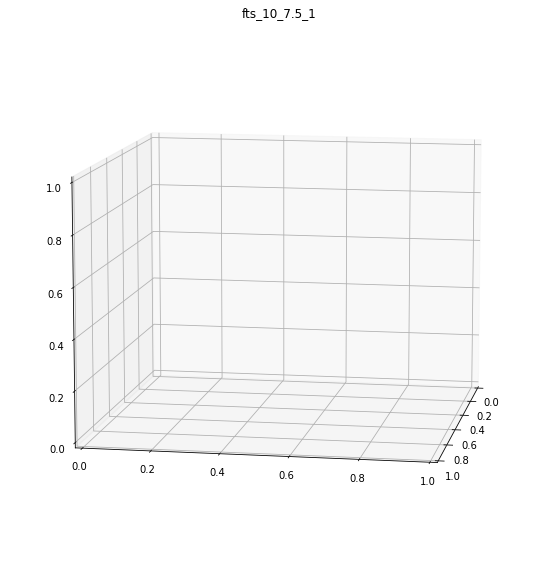

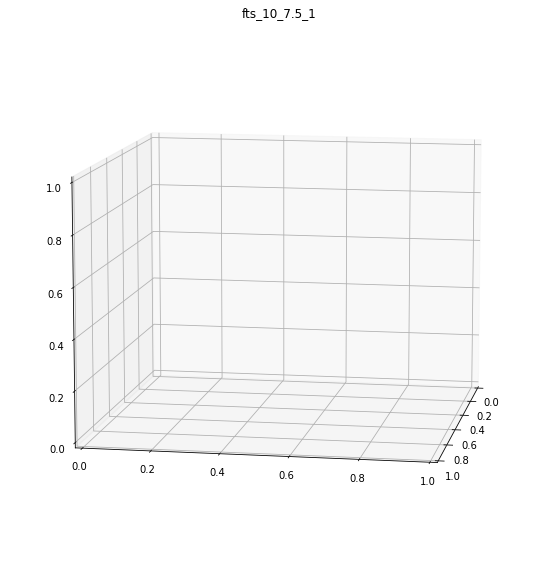

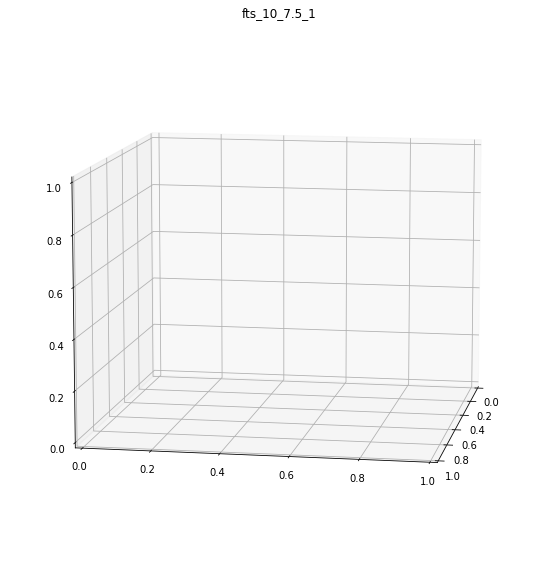

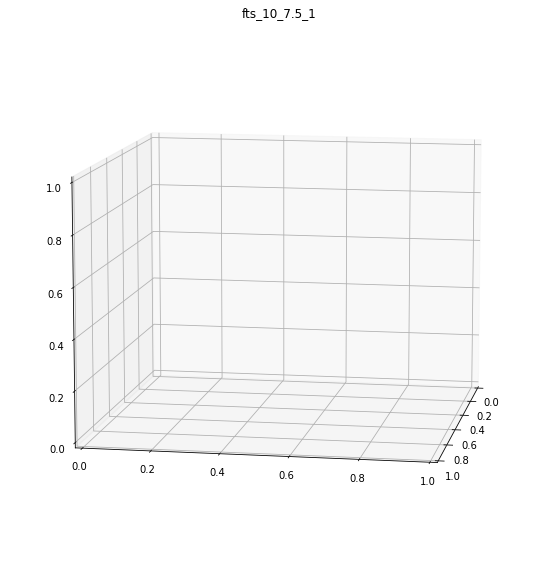

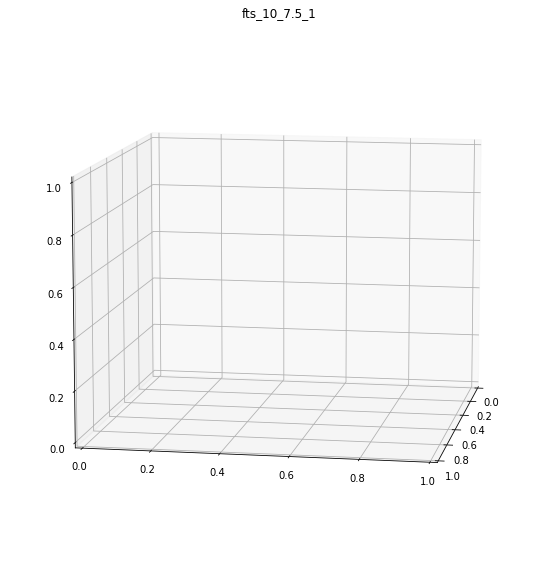

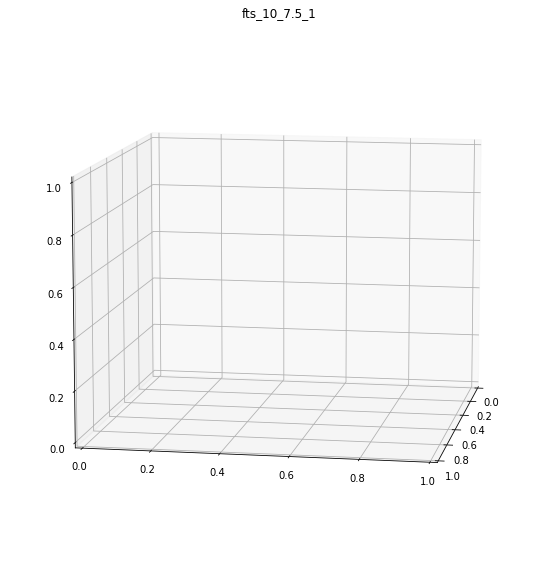

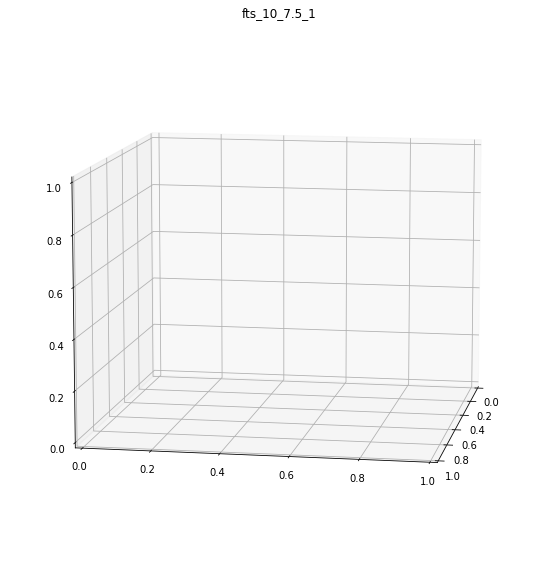

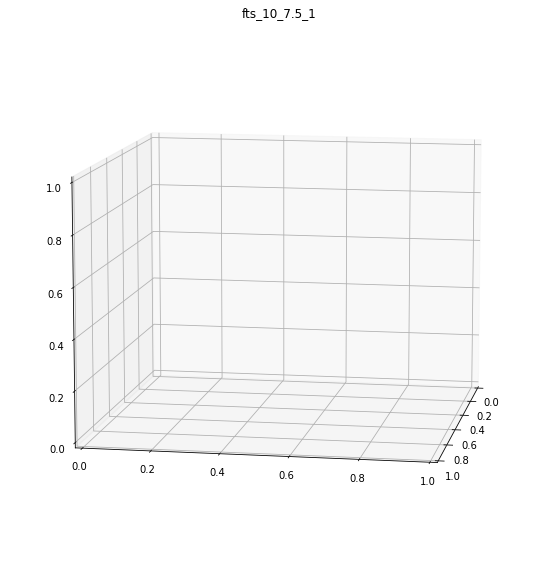

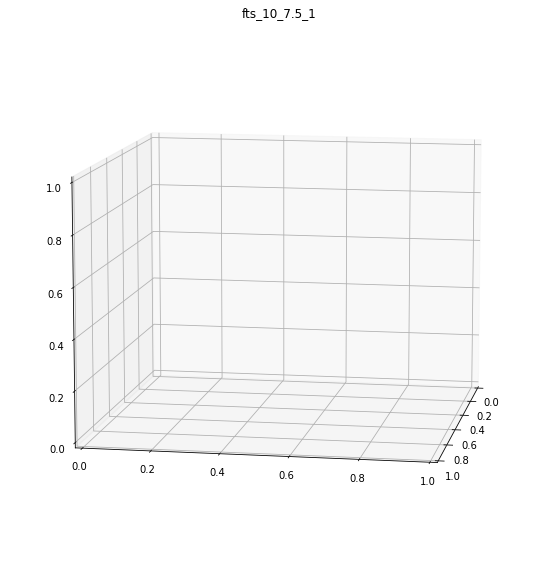

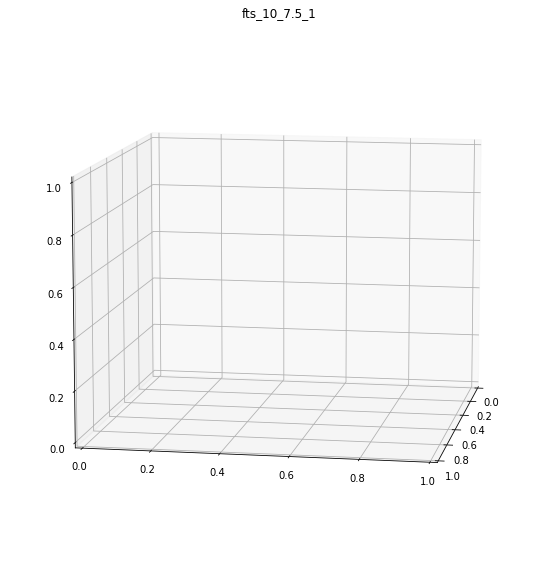

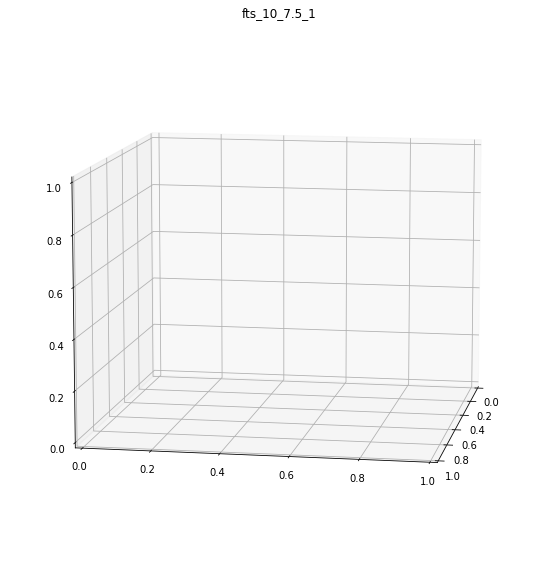

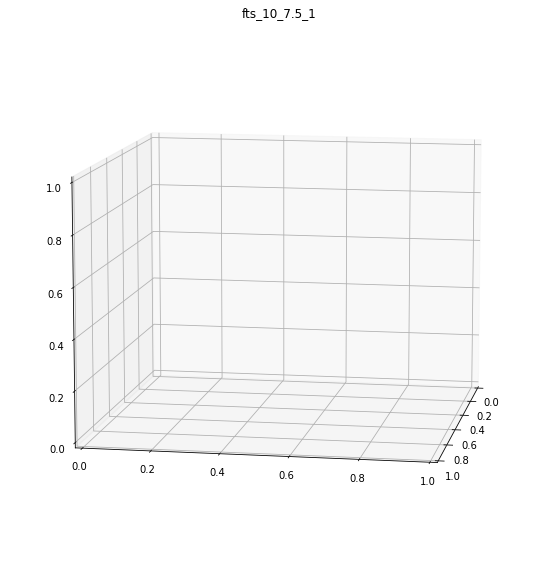

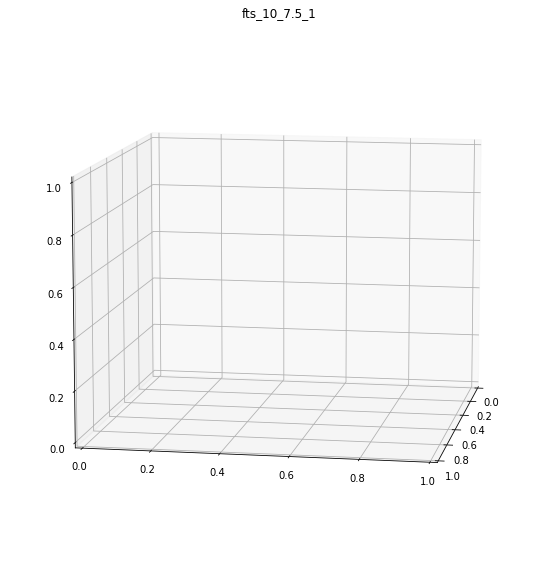

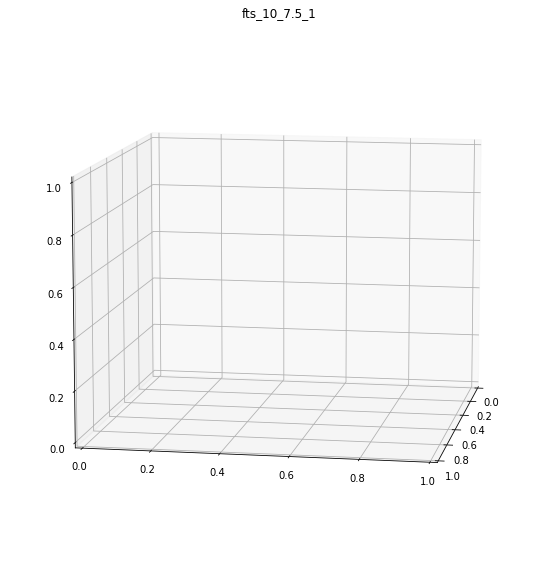

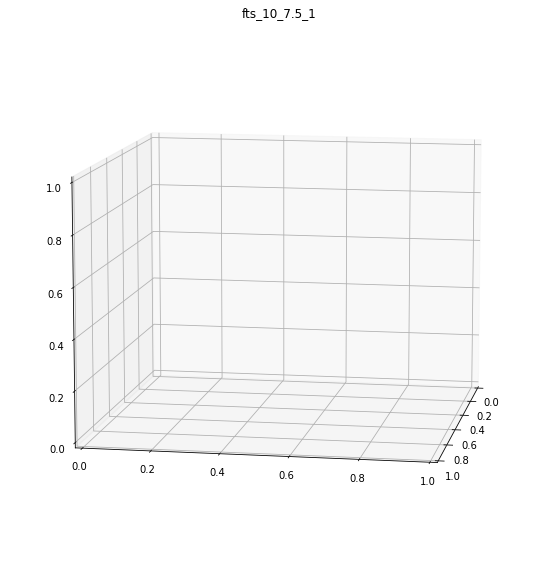

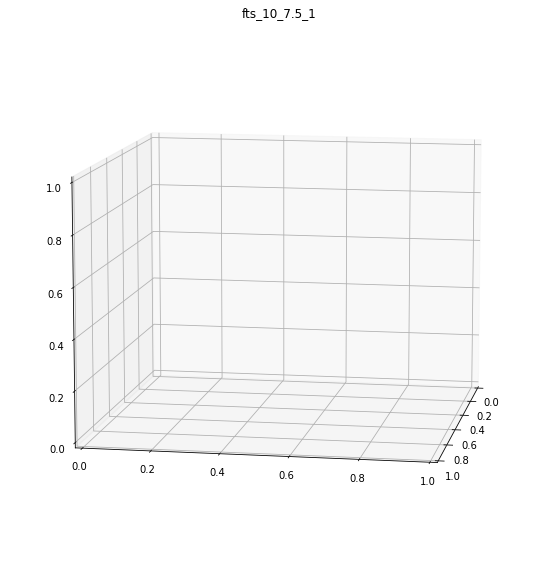

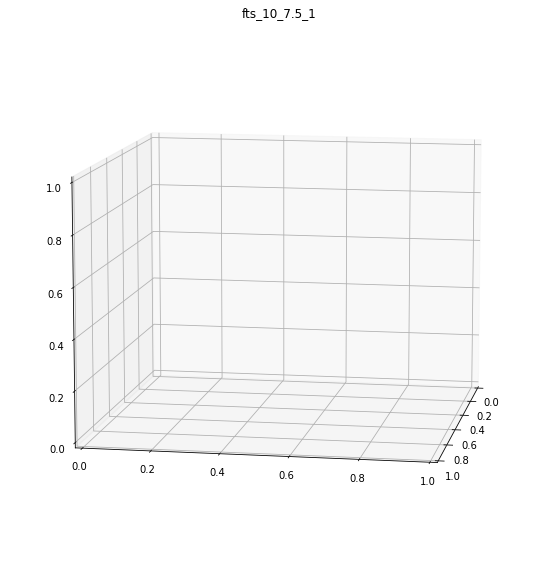

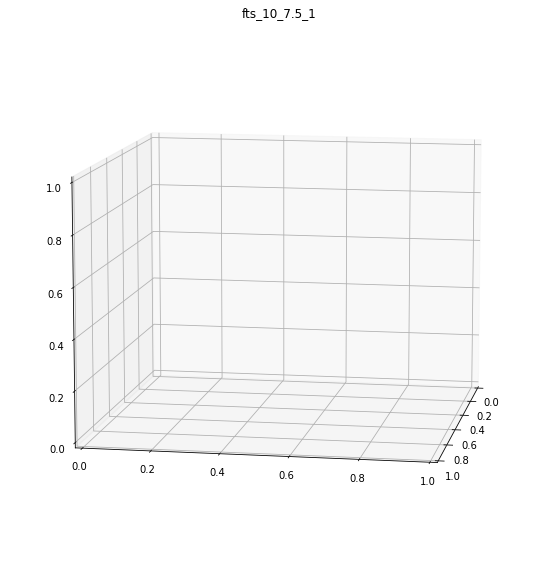

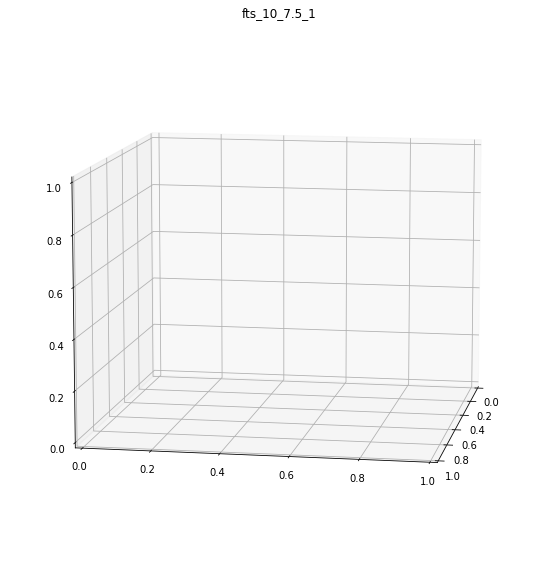

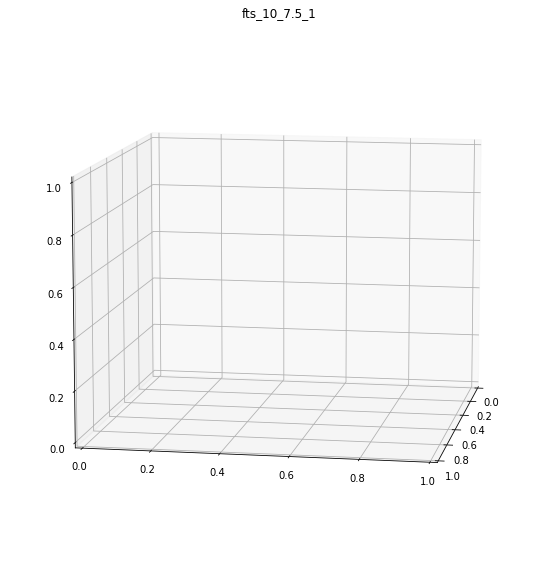

In [5]:
from visualization import points_visualization

points_visualization.create_gif_for_given_shot(names[1],x[1])

In [38]:
print(x.shape)

torch.Size([1371, 50, 100])


In [137]:

def feature_selection(remove_features):
    
    num_of_landmark_to_remove = len(remove_features)*4
    copy = x.clone() # don't change x
    
    SEQ_LEN = 50
    ALL_EXISTING_FEATURES = 4 * 25
    NUM_FEATURES = 4 * 25 - num_of_landmark_to_remove 
    amount_of_shots= len(x)
    single_shot_x = np.zeros((SEQ_LEN, NUM_FEATURES))
    new_frame_after_removing_features=np.zeros(NUM_FEATURES)
    shot_index = 0
    i=0
    copy.numpy()
    new = np.zeros((amount_of_shots, SEQ_LEN, NUM_FEATURES))
    for shot in copy:
        shot_data = []
        for frame in shot:
            #iterate over requestes landmarks
            for i in range(0,len(remove_features)):
                np.concatenate(new_frame_after_removing_features,frame[remove_features[i]*4:remove_features[i]*4+3])
                print(new_frame_after_removing_features.size)
            if i == SEQ_LEN-1:
                i=0
                break
            single_shot_x[i] = np.array(new_frame_after_removing_features) 
            i+=1
            new_frame_after_removing_features=[]
        shot_index += 1
        if shot_index == amount_of_shots-1:
         break
        new[shot_index] = np.nan_to_num(single_shot_x)


    return new

#Usage example - remove head landmarks 
head_landmarks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#TODO deal with input like [5,10,20] - remove 3 points but unorder and continuous
data = feature_selection(head_landmarks)
print(data.shape)



TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.